# Greece Data Generation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

---



Install Libraries need for proj

In [ ]:
!apt-get update && \
apt-get install -y gdal-bin libgdal-dev && \
pip install osmnx rasterio matplotlib==3.7.1 GDAL requests shapely contextily pyproj Dask "cdsapi>=0.7.2"
!pip install rasterio



Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,519 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,859 kB]
Get:13 https://cloud.r-project.org/bin/linux/ubuntu jammy-

Import all the needed Libraries

In [ ]:
import pandas as pd
import random
from datetime import datetime, timedelta
import calendar
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import numpy as np
import dask.array as da
import contextily as ctx
import pyproj
from sklearn.preprocessing import OrdinalEncoder
import requests
import shapely
import osmnx as ox
import xarray as xr
import geopandas as gpd
import json
import cdsapi
import os

# ox.config(use_cache=True, log_console=True)

# Global Variables


---




In [ ]:
# Load the Greece Shapefile with Correct CRS
shapefile_path = '/content/drive/MyDrive/Greece_prj_content/gr.shx'
greece_shapefile = gpd.read_file(shapefile_path)

# Define directory and file paths
directory = '/content/drive/MyDrive/Greece_prj_content/Out'

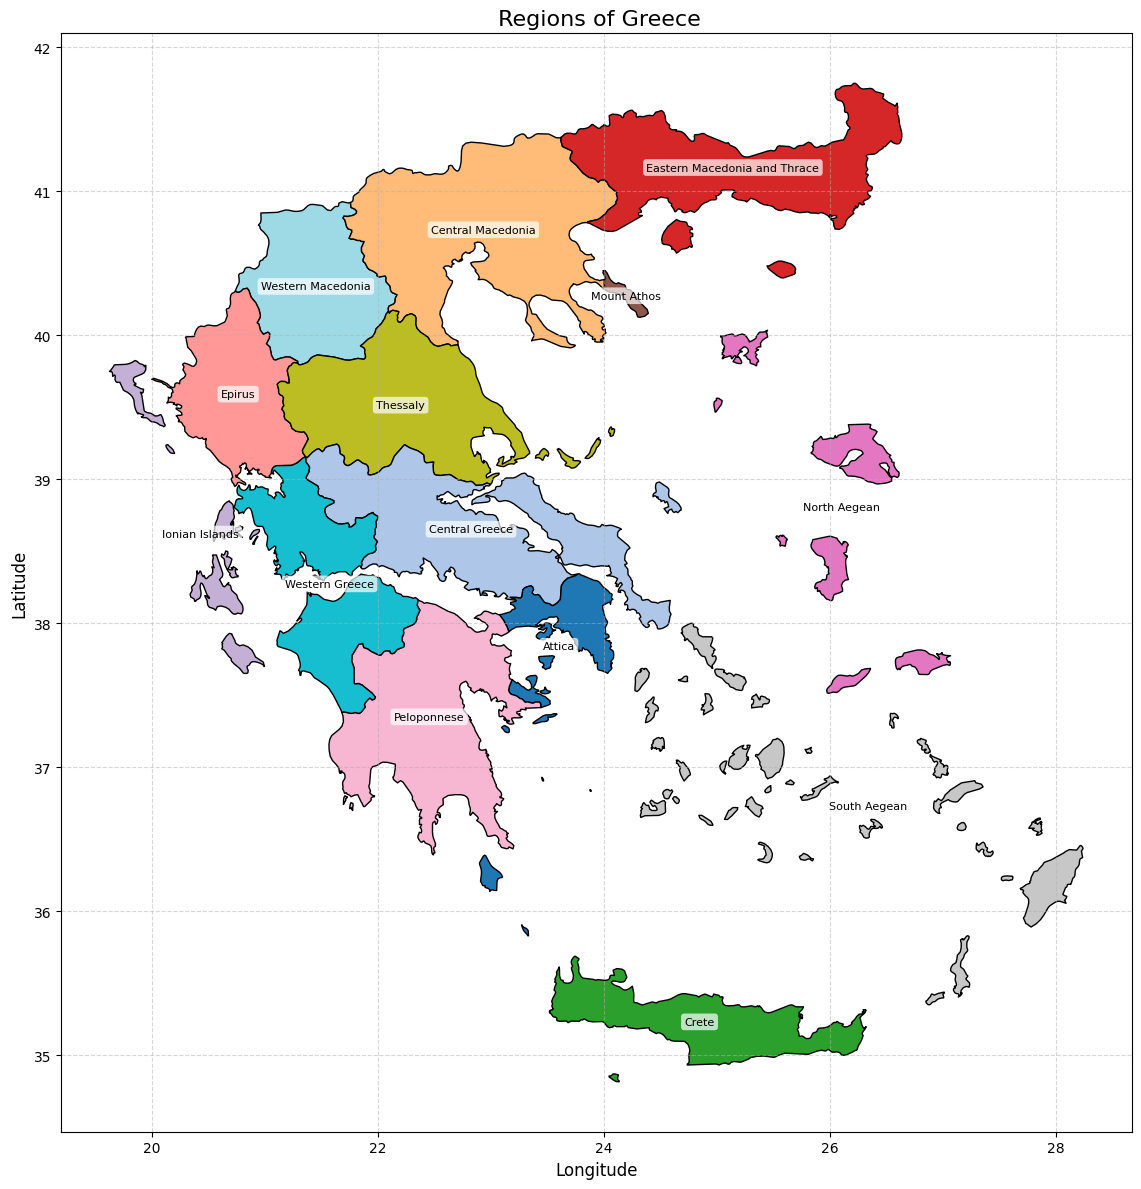

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the Greece Shapefile with Correct CRS
shapefile_path = '/content/drive/MyDrive/Greece_prj_content/gr.shx'
greece_shapefile = gpd.read_file(shapefile_path)

# Check the CRS and reproject to WGS84 if needed
if greece_shapefile.crs != "EPSG:4326":
    greece_shapefile = greece_shapefile.to_crs("EPSG:4326")

# Map region IDs to names
region_names = {
    0: "Western Macedonia",
    1: "Epirus",
    2: "Central Macedonia",
    3: "Eastern Macedonia and Thrace",
    4: "Mount Athos",
    5: "Thessaly",
    6: "Central Greece",
    7: "Attica",
    8: "Peloponnese",
    9: "Western Greece",
    10: "Crete",
    11: "South Aegean",
    12: "North Aegean",
    13: "Ionian Islands",
}

# Add region names to the GeoDataFrame
greece_shapefile['region_name'] = greece_shapefile.index.map(region_names)

# Plot the shapefile with color coding
fig, ax = plt.subplots(figsize=(12, 12))
greece_shapefile.plot(
    column='region_name',  # Use region_name for color coding
    cmap='tab20',          # Use a colormap (e.g., 'tab20' for categorical)
    legend=False,          # Remove the legend
    ax=ax,
    edgecolor="black"      # Add black borders
)

# Add region labels
for idx, row in greece_shapefile.iterrows():
    if row.geometry.is_empty or row.geometry is None:
        continue  # Skip invalid geometries
    # Get the centroid of the geometry for label placement
    centroid = row.geometry.centroid
    # Add the label (use the region_name column)
    ax.text(
        centroid.x, centroid.y,
        row['region_name'],  # Use region name for the label
        fontsize=8,
        color="black",
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.7)  # Optional background
    )

# Add titles and labels
ax.set_title(" Regions of Greece", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()



# Data extraction Functions

---



### 1.   Functions for **Solar Irradiance**





In [ ]:
def get_ghi_data_pvgis(latitude, longitude, year, month):
    """
    Fetches daily GHI data for a random day in a given month and year from PVGIS.

    Args:
      latitude: Latitude of the location.
      longitude: Longitude of the location.
      year: The year for which to fetch data (e.g., 2023).
      month: The month for which to fetch data (1-12).

    Returns:
      A float representing the average GHI for the day, or None if data is not found.
    """
    try:
        # Generate a random day within the month
        start_date = datetime(year, month, 1)
        end_date = start_date + timedelta(days=calendar.monthrange(year, month)[1] - 1)
        random_day = random.randint(1, (end_date - start_date).days)
        random_date = start_date + timedelta(days=random_day - 1)

        # Construct the URL for PVGIS TMY API
        base_url = "https://re.jrc.ec.europa.eu/api/tmy?"
        params = {
            "lat": latitude,
            "lon": longitude,
            "usehorizon": "1",  # Use horizon profile
            "startyear": year - 9,
            "endyear": year,
            "outputformat": "json",  # Get output in JSON format
        }

        response = requests.get(base_url, params=params)
        response.raise_for_status()

        data = response.json()

        # Extract GHI (G(h)) for the random day from the JSON response

        daily_ghi_values = [
            hour["G(h)"]
            for hour in data["outputs"]["tmy_hourly"][
                random_day * 24 - 24 : random_day * 24
            ]
        ]  # Extract for the whole day
        max_ghi = max(daily_ghi_values) if daily_ghi_values else None
        avg_ghi = sum(daily_ghi_values) / len(daily_ghi_values) if daily_ghi_values else None
        # ghi_value = data["outputs"]["tmy_hourly"][random_day * 24 - 1]["G(h)"]
        # print(max_ghi)
        return max_ghi, avg_ghi

    except requests.exceptions.RequestException as e:
        # print(f"Error fetching data: {e}")
        return None
    except Exception as e:
        # print(f"Error processing data: {e}")
        return None

### 2.   Functions for **Power Grid Distribution**



In [ ]:
def power_grid_data(place_name, greece_shapefile):
  power_grid = ox.graph_from_place(
      place_name, network_type="drive_service", custom_filter='["power"~"line"]'
  )

  power_grid = ox.graph_from_polygon(
      greece_shapefile.unary_union,
      network_type="drive_service",
      custom_filter='["power"~"line"]',
  )

  power_lines_gdf = ox.graph_to_gdfs(power_grid, nodes=False, edges=True)

  return power_lines_gdf

def visualize_power_grid(power_lines_gdf):
  """
  Visualizes the grid data on a map.

  Args:
    power_lines_gdf: A shapefile defining the geographical boundaries of Greece.
  """
  try:
    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the shapefile (Greece boundary)
    greece_shapefile.plot(ax=ax, color='lightgray', edgecolor='black')

    # Plot the power lines
    power_lines_gdf.plot(ax=ax, color='red', linewidth=0.5)

    # Set title and axis labels
    ax.set_title('Power Grid of Greece')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Show the plot
    plt.show()

  except Exception as e:
    print(f"Error visualizing power grid data: {e}")

### 3. Functions for Agricultural Data



In [ ]:
def calculate_slope(dem, cellsize):
    """Calculates slope in degrees using a 3x3 window and Dask.

    Args:
      dem: A Dask array representing the DEM.
      cellsize: The pixel size of the DEM.

    Returns:
      A Dask array representing the slope in degrees.
    """

    # Calculate x and y derivatives using central differences
    dzdx = da.zeros_like(dem, dtype=float)
    dzdy = da.zeros_like(dem, dtype=float)

    dzdx[:, 1:-1] = (dem[:, 2:] - dem[:, :-2]) / (2 * cellsize)
    dzdy[1:-1, :] = (dem[2:, :] - dem[:-2, :]) / (2 * cellsize)

    # Handle edge cases with forward/backward differences
    dzdx[:, 0] = (dem[:, 1] - dem[:, 0]) / cellsize
    dzdx[:, -1] = (dem[:, -1] - dem[:, -2]) / cellsize
    dzdy[0, :] = (dem[1, :] - dem[0, :]) / cellsize
    dzdy[-1, :] = (dem[-1, :] - dem[-2, :]) / cellsize

    # Calculate slope
    slope = da.arctan(da.sqrt(dzdx**2 + dzdy**2)) * 180 / np.pi
    return slope

# Solar Irradiance

---



Uses the **PHOTOVOLTAIC GEOGRAPHICAL INFORMATION SYSTEM**:
https://re.jrc.ec.europa.eu/pvg_tools/en/

Initialize Variables

In [ ]:
# Create an empty list to store data
data = []
avg_ghi_vals = []
max_ghi_vals = []

# Get current year
current_year = datetime.now().year

# file path for solar irradinace csv
file_path_slr_irr = os.path.join(directory, 'SolarIrradiance.csv')

# Number of points to sample per region
points_per_region = 10  # used to minimize the time taken to knit

# Add new columns to the GeoDataFrame to store lists of GHI values
greece_shapefile['AVG_GHI'] = None
greece_shapefile['MAX_GHI'] = None

In [ ]:
# Check if the file exists
if os.path.exists(file_path_slr_irr):
    df = pd.read_csv(file_path_slr_irr)
    # Iterate over the rows of the GeoDataFrame
    for i, region in enumerate(greece_shapefile.geometry):
        # Get the bounding box of the region
        minx, miny, maxx, maxy = region.bounds

        # Filter the DataFrame based on the region's bounds
        region_df = df[
            (df['Location'].str.split(',').str[0].astype(float) >= miny)
            & (df['Location'].str.split(',').str[0].astype(float) <= maxy)
            & (df['Location'].str.split(',').str[1].astype(float) >= minx)
            & (df['Location'].str.split(',').str[1].astype(float) <= maxx)
        ]

        # Extract the Avg GHI and Max GHI values as lists
        avg_ghi_values = region_df['Avg GHI'].tolist()
        max_ghi_values = region_df['Max GHI'].tolist()

        # Assign the lists of values to the corresponding columns in the GeoDataFrame
        greece_shapefile.loc[i, 'AVG_GHI'] = np.mean(avg_ghi_values)
        greece_shapefile.loc[i, 'MAX_GHI'] = np.mean(max_ghi_values)
else:
    # Sample multiple points within each region of the Greece shapefile
    for i, region in enumerate(greece_shapefile.geometry):
        for _ in range(points_per_region):
            # Generate a random point within the region's bounds
            minx, miny, maxx, maxy = region.bounds
            while True:
                point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
                if region.contains(point):  # Ensure point is within the region
                    break

            latitude = point.y
            longitude = point.x

            for month in range(1, 13):
                max_ghi, avg_ghi = get_ghi_data_pvgis(latitude, longitude, current_year - 1, month)
                if avg_ghi is not None:
                    data.append([f"{latitude},{longitude}", month, max_ghi, avg_ghi])
                    # Assign the average GHI to the corresponding region in the GeoDataFrame
                    avg_ghi_vals.append(avg_ghi)
                    max_ghi_vals.append(max_ghi)
        # Store the list of ghi for each region
        greece_shapefile.loc[i, 'AVG_GHI'] = np.mean(avg_ghi)
        greece_shapefile.loc[i, 'MAX_GHI'] = np.mean(max_ghi)


    # Create a pandas DataFrame
    df = pd.DataFrame(data, columns=["Location", "Month", "Max GHI", "Avg GHI"])
print(df)

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
greece_shapefile

,id,name,source,geometry,region_name,AVG_GHI,MAX_GHI
0,GRC,Dytiki Makedonia,https://simplemaps.com,"POLYGON ((20.73955 40.30917, 20.75504 40.33862...",Western Macedonia,78.331495,369.181373
1,GRD,Ipeiros,https://simplemaps.com,"POLYGON ((20.73955 40.30917, 20.74285 40.30555...",Epirus,71.371032,344.64881
2,GRB,Kentriki Makedonia,https://simplemaps.com,"POLYGON ((22.09481 40.16737, 22.09191 40.1869,...",Central Macedonia,81.833984,379.854167
3,GRA,Anatoliki Makedonia kai Thraki,https://simplemaps.com,"MULTIPOLYGON (((23.85434 40.78115, 23.85439 40...",Eastern Macedonia and Thrace,75.993056,362.681818
4,GR69,Ayion Oros,https://simplemaps.com,"POLYGON ((24.00167 40.31977, 24.00487 40.32922...",Mount Athos,57.676042,280.141667
5,GRE,Thessalia,https://simplemaps.com,"MULTIPOLYGON (((21.29124 39.80483, 21.30364 39...",Thessaly,78.604371,365.671569
6,GRH,StereÃ¡ EllÃ¡da,https://simplemaps.com,"MULTIPOLYGON (((21.36235 39.15394, 21.37568 39...",Unknown,81.174934,376.642857
7,GRA1,Attiki,https://simplemaps.com,"MULTIPOLYGON (((23.21337 38.16027, 23.21784 38...",Attica,89.25434,416.916667
8,GRJ,Peloponnisos,https://simplemaps.com,"MULTIPOLYGON (((23.07632 38.05974, 23.07676 38...",Peloponnese,90.911458,420.494048
9,GRG,Dytiki Ellada,https://simplemaps.com,"MULTIPOLYGON (((21.06031 39.03905, 21.05869 39...",Western Greece,81.651042,377.029762


In [ ]:
if not os.path.exists(file_path_slr_irr):
  # Create the directory if it doesn't exist
  os.makedirs(directory, exist_ok=True)
  # Save as CSV
  df.to_csv(file_path_slr_irr, index=False)

### Visualization

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the Greece shapefile with color based on 'AVG_GHI'
greece_shapefile.plot(
    column="AVG_GHI",  # Use the 'AVG_GHI' column for color mapping
    cmap="Oranges",  # Use the 'Oranges' colormap
    ax=ax,
)

# Add a colorbar for better visualization
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap="Oranges", norm=plt.Normalize(vmin=greece_shapefile["AVG_GHI"].min(), vmax=greece_shapefile["AVG_GHI"].max()))
sm._A = []  # This is necessary to prevent an error
cbar = fig.colorbar(sm, ax=ax)

# Set plot title and labels
ax.set_title("Maximum GHI in Greece")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

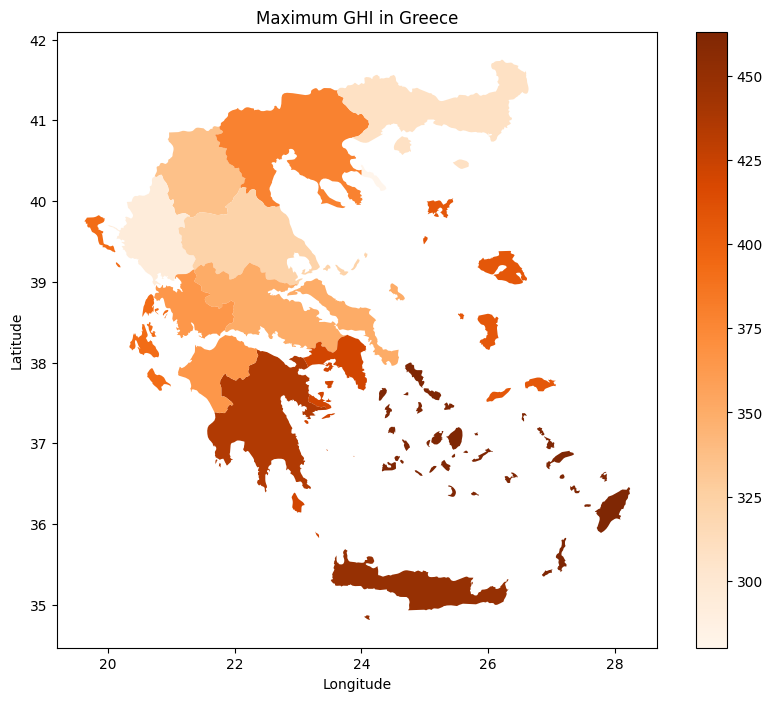

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the Greece shapefile with color based on 'AVG_GHI'
greece_shapefile.plot(
    column="MAX_GHI",  # Use the 'AVG_GHI' column for color mapping
    cmap="Oranges",  # Use the 'Oranges' colormap
    ax=ax,
)

# Add a colorbar for better visualization
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap="Oranges", norm=plt.Normalize(vmin=greece_shapefile["MAX_GHI"].min(), vmax=greece_shapefile["MAX_GHI"].max()))
sm._A = []  # This is necessary to prevent an error
cbar = fig.colorbar(sm, ax=ax)

# Set plot title and labels
ax.set_title("Maximum GHI in Greece")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

# Power Line Data

---



Uses the **OpenStreetMap**: https://www.openstreetmap.org/#map=6/51.33/10.45

Variables

In [ ]:
file_path_pwr = os.path.join(directory, 'PowerLine.csv')

In [ ]:
if not os.path.exists(file_path_pwr):
  power_grid_gdf = power_grid_data("Greece", greece_shapefile)
  # Create the directory if it doesn't exist
  os.makedirs(directory, exist_ok=True)
  # Save as CSV
  power_grid_gdf.to_csv(file_path_pwr, index=False)
else:
  # Load the CSV file into a pandas DataFrame
  power_grid_df = pd.read_csv(file_path_pwr)

  # Convert the 'geometry' column from WKT to Shapely geometry objects
  power_grid_df['geometry'] = power_grid_df['geometry'].apply(shapely.wkt.loads)

  # Create a GeoDataFrame from the DataFrame
  power_grid_gdf = gpd.GeoDataFrame(power_grid_df, geometry='geometry')
  power_grid_gdf.crs = greece_shapefile.crs

In [ ]:
power_grid_gdf

,osmid,name,oneway,reversed,length,geometry
0,249108722,Υ/Σ ΚΑΣΤΡΑΚΙ-Υ/Σ ΤΡΙΧΩΝΙΔΑ-Υ/Σ ΑΙΤΩΛΙΚΟ,False,False,25960.980061,"LINESTRING (21.36403 38.73804, 21.36397 38.736..."
1,973584399,NaN,False,False,37.466425,"LINESTRING (21.36403 38.73804, 21.36388 38.738..."
2,973584400,NaN,False,True,36.948596,"LINESTRING (21.36403 38.73804, 21.36379 38.738..."
3,143520202,NaN,False,True,5519.868271,"LINESTRING (21.36467 38.73826, 21.36626 38.738..."
4,973584393,NaN,False,False,66.141507,"LINESTRING (21.36467 38.73826, 21.36413 38.738..."
...,...,...,...,...,...,...
2027,"[251579385, 251579391]",NaN,False,True,136.653047,"LINESTRING (23.32716 38.27922, 23.32792 38.279..."
2028,251579405,Ζυγοί 400kV,False,False,31.830588,"LINESTRING (23.32717 38.27951, 23.32716 38.27922)"
2029,148899576,NaN,False,False,13201.898584,"LINESTRING (22.45153 40.61119, 22.4518 40.6106..."
2030,92421828,Εύοσμος - Πτολεμαΐδα,False,False,40896.508291,"LINESTRING (22.45153 40.61119, 22.45273 40.611..."


### Visualization

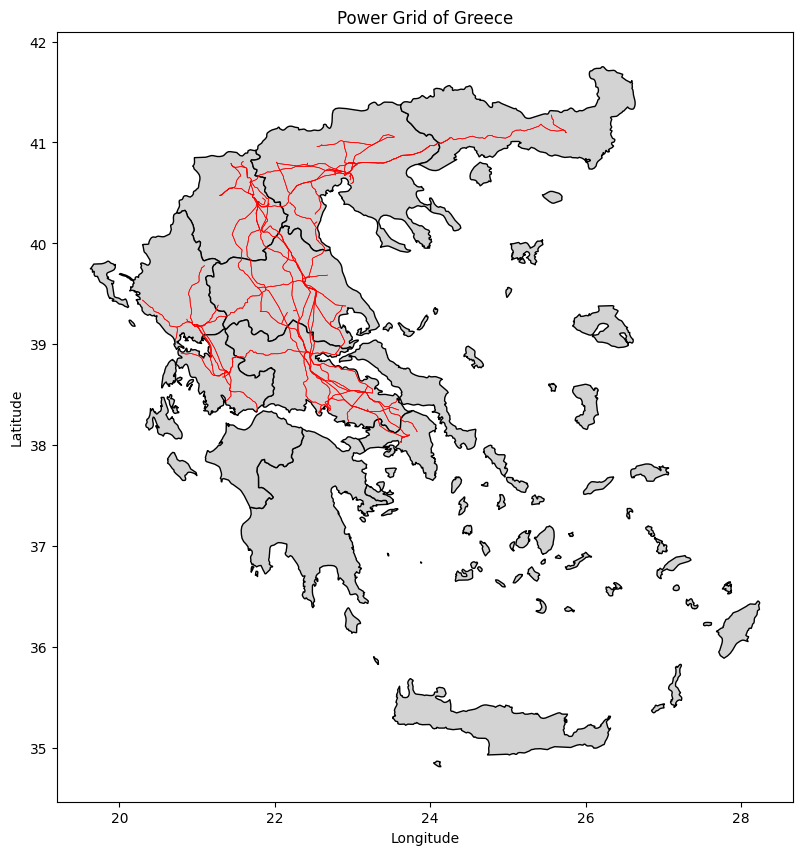

In [ ]:
visualize_power_grid(power_grid_gdf)

# Agricultural Data

Uses the **EUROGEOGRAPHICS**: https://www.mapsforeurope.org/access-data

In [ ]:
# Load the EuroDEM with rasterio
with rasterio.open("/content/drive/MyDrive/Greece_prj_content/EuroDEM/eurodem.tif") as src:
    # Load Greece shapefile
    greece = greece_shapefile

    # Reproject the shapefile to the DEM's CRS if necessary
    if greece.crs != src.crs:
        greece = greece.to_crs(src.crs)

    # Mask the DEM to the boundaries of Greece
    greece_dem, greece_transform = mask(src, greece.geometry, crop=True)

    # Update the DEM profile
    greece_profile = src.profile.copy()
    greece_profile.update({
        "height": greece_dem.shape[1],
        "width": greece_dem.shape[2],
        "transform": greece_transform
    })

    # Convert the masked DEM to a Dask array
    dem_data = da.from_array(greece_dem[0], chunks=(2048, 2048))
    cellsize = greece_transform[0]


In [ ]:
# Get DEM dimensions
height, width = dem_data.shape
print(height, width)

12484 15505


In [ ]:
# Calculate the slope
try:
    # Calculate the slope
    slope_degrees = calculate_slope(dem_data, cellsize)
except Exception as e:
    print(f"Error calculating slope: {e}")


In [ ]:
# Define slope thresholds for suitability (in degrees)
suitable_slope = (slope_degrees >= 0) & (slope_degrees <= 5)

In [ ]:
# Use greece_profile instead of dem_profile
with rasterio.open('/content/drive/MyDrive/Greece_prj_content/EuroDEM/suitable_slope_greece.tif', 'w', **greece_profile) as dst:
    dst.write(suitable_slope.astype(rasterio.uint8), 1)

In [ ]:
print(f"Pixel size: {cellsize} x {abs(greece_transform[4])}")
print(f"CRS: {src.crs}")

import rasterio
with rasterio.open("/content/drive/MyDrive/Greece_prj_content/EuroDEM/eurodem.tif") as src:
    print(src.crs)         # Displays the CRS
    print(src.transform)   # Displays the affine transform, including pixel size



Pixel size: 2.0 x 2.0
CRS: GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Arcsecond",4.84813681109536E-06],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Arcsecond",4.84813681109536E-06],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
| 2.00, 0.00,-103385.85|
| 0.00,-2.00, 262763.85|
| 0.00, 0.00, 1.00|


### Visualization

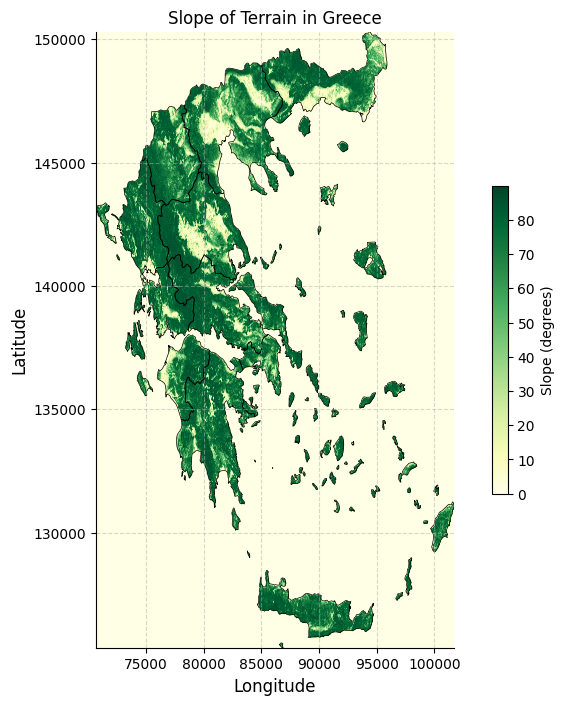

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))  # Adjust figure size as needed
# Plot the slope data with a more intuitive colormap
im = ax.imshow(
    slope_degrees,
    cmap="YlGn",  # Use a yellow-green colormap
    extent=[
        greece_transform[2],
        greece_transform[2]
        + greece_profile["width"] * greece_transform[0],
        greece_transform[5]
        + greece_profile["height"] * greece_transform[4],
        greece_transform[5],
    ],
    origin="upper",
)

# Add a colorbar
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label("Slope (degrees)")

# Plot the Greece shapefile boundaries
greece.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Remove axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set plot title
ax.set_title("Slope of Terrain in Greece")

plt.show()

# Soil Data

Uses the **JOINT RESEARCH CENTRE European Soil Data Centre (ESDAC)**: https://esdac.jrc.ec.europa.eu/

In [ ]:
# 1. Load the Data
soil_20m = gpd.read_file("/content/drive/MyDrive/Greece_prj_content/Soil_Data/SGDB_PTR.shx")

# 2. Filter the soil data for Greece
soil_data = gpd.overlay(soil_20m, greece_shapefile, how='intersection')
soil_data.dropna(subset=['OC_TOP'], inplace=True)


In [ ]:
# soil_data.to_csv('output.csv', index=False)
# from google.colab import files
# files.download('output.csv')  # Download the file

In [ ]:
# Print the column names of soil_20m
print("Columns in SGDBE4_0_20m.shp:")
print(soil_20m.columns)

# Print the column names of countries
print("\nColumns in SGDBE4_0_20m.dbf:")
print(soil_data.columns)

Columns in SGDBE4_0_20m.shp:
Index(['OBJECTID', 'sde_SDE_SG', 'SOIL_', 'SOIL_ID', 'PERIMETER', 'SMU',
       'STU_DOM', 'PCAREA', 'NONSOIL', 'FAO90FU', 'WM1', 'TXSRFDO', 'WRBFU',
       'SLOPESE', 'PARMASE3', 'PARMASE2', 'PARMASE1', 'PARMADO3', 'PARMADO2',
       'PARMADO1', 'FAO85LV3', 'FAO85LV2', 'FAO85LV1', 'FAO90LV2', 'FAO90LV1',
       'WRBSPE2', 'WRBADJ2', 'WRBSPE1', 'WRBADJ1', 'WRBLV1', 'WM2', 'WR', 'IL',
       'ROO', 'TXDEPCHG', 'TXSUBSE', 'TXSUBDO', 'TXSRFSE', 'AGLIM2', 'AGLIM1',
       'USESE', 'USEDO', 'PARMASE', 'PARMADO', 'ZMAX', 'ZMIN', 'SLOPEDO',
       'FAO85FU', 'ERODI', 'TXEROD', 'CRUSTING', 'PHYSCHIM', 'TXCRUST',
       'EAWC_SUB', 'AWC_SUB', 'EAWC_TOP', 'AWC_TOP', 'PD_SUB', 'PD_TOP',
       'STR_SUB', 'STR_TOP', 'TD', 'VS', 'DR', 'BS_SUB', 'BS_TOP', 'CEC_SUB',
       'CEC_TOP', 'MIN_SUB', 'MIN_TOP', 'MIN_', 'DIFF', 'ATC', 'HG', 'DIMP',
       'DGH', 'PMH', 'PEAT', 'OC_TOP', 'MAT1HEV', 'ALT', 'USE_', 'AGLI2NNI',
       'AGLI1NNI', 'TEXT', 'SHAPE_area', 'SHAPE_len', 

In [ ]:
print('OC_TOP:', soil_data['OC_TOP'].unique())
print('AWC_TOP:', soil_data['AWC_TOP'].unique())
print('CEC_TOP:', soil_data['CEC_TOP'].unique())

OC_TOP: ['L' 'V' 'M']
AWC_TOP: ['VH' 'H' 'M' '#']
CEC_TOP: ['L' 'M' 'H']


In [ ]:
# Create a custom encoder
class CustomOrdinalEncoder(OrdinalEncoder):
    def __init__(self, mapping):
        super().__init__()
        self.mapping = mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Use applymap instead of map to apply the mapping dictionary to each element
        # of the DataFrame. This will properly convert the categorical values
        # to their corresponding numerical values based on the mapping provided.
        X_encoded = X.applymap(lambda x: self.mapping.get(x))
        # Handle NaN values if necessary using fillna
        X_encoded = X_encoded.fillna(-1).astype(int) # Replace -1 with your preferred value
        return X_encoded.values.reshape(-1, 1)


# Define the order of the categories and their corresponding numerical values
texture_mapping = {
    'L': 2,    # Low
    'M': 6,   # Medium
    'H': 10,   # High
    'V': 0.5,   # Very High
}

# Create an ordinal encoder
encoder = CustomOrdinalEncoder(mapping=texture_mapping)

# Fit and transform the data
soil_data['OC_TOP'] = encoder.fit_transform(soil_data[['OC_TOP']])

<ipython-input-159-c3174ed88871>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_encoded = X.applymap(lambda x: self.mapping.get(x))


In [ ]:
# Define the order of the categories
texture_mapping = {
    'L': 15,    # Low
    'M': 40,   # Medium
    'H': 60,   # High
}

# Create an ordinal encoder
encoder = CustomOrdinalEncoder(mapping=texture_mapping)

# Fit and transform the data
soil_data['CEC_TOP'] = encoder.fit_transform(soil_data[['CEC_TOP']])

<ipython-input-159-c3174ed88871>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_encoded = X.applymap(lambda x: self.mapping.get(x))


In [ ]:
# Define the order of the categories
texture_mapping = {
    '#': 0,
    'L': 100,    # Low
    'M': 140,   # Medium
    'H': 190,   # High
    'VH': 220,   # Very High
}

# Create an ordinal encoder
encoder = CustomOrdinalEncoder(mapping=texture_mapping)

# Fit and transform the data
soil_data['AWC_TOP'] = encoder.fit_transform(soil_data[['AWC_TOP']])

<ipython-input-159-c3174ed88871>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_encoded = X.applymap(lambda x: self.mapping.get(x))


In [ ]:
print('OC_TOP:', soil_data['OC_TOP'].unique())
print('AWC_TOP:', soil_data['AWC_TOP'].unique())
print('CEC_TOP:', soil_data['CEC_TOP'].unique())

OC_TOP: [2 0 6]
AWC_TOP: [220 190 140   0]
CEC_TOP: [15 40 60]


In [ ]:
# 4. Create a composite soil fertility index
soil_data['OC_TOP'] = pd.to_numeric(soil_data['OC_TOP'], errors='coerce')
soil_data['AWC_TOP'] = pd.to_numeric(soil_data['AWC_TOP'], errors='coerce')
soil_data['CEC_TOP'] = pd.to_numeric(soil_data['CEC_TOP'], errors='coerce')
# soil_data['ERODIBI'] = pd.to_numeric(soil_data['ERODIBI'], errors='coerce')

soil_data['OC_TOP'] = soil_data['OC_TOP'].fillna(0)
soil_data['AWC_TOP'] = soil_data['AWC_TOP'].fillna(0)
soil_data['CEC_TOP'] = soil_data['CEC_TOP'].fillna(0)
# soil_data['ERODIBI'] = soil_data['ERODIBI'].fillna(0)

soil_data['fertility_index'] = (
    0.3 * soil_data['OC_TOP'] +
    0.4 * soil_data['AWC_TOP'] +
    0.3 * soil_data['CEC_TOP']
)
soil_data['fertility_index'] = soil_data['fertility_index'].astype('int64')

# Normalize the fertility index to a 0-100 scale
min_value = soil_data['fertility_index'].min()
max_value = soil_data['fertility_index'].max()

soil_data['fertility_index_normalized'] = (
    (soil_data['fertility_index'] - min_value) /
    (max_value - min_value)
) * 100

# Optional: Convert to integer for simplicity
soil_data['fertility_index_normalized'] = soil_data['fertility_index_normalized'].astype('int64')

# Display the updated DataFrame
print(soil_data)


     OBJECTID  sde_SDE_SG  SOIL_  SOIL_ID   PERIMETER      SMU  STU_DOM  \
0       45859         0.0  45860    45859   420499.80  3590009  3590047   
1       46623         0.0  46624    46623  1241948.00  3590016  3590083   
2       46663         0.0  46664    46663   240075.00  3590006  3590028   
3       46718         0.0  46719    46718   717180.20  3590014  3590071   
4       46760         0.0  46761    46760    69989.55   300580   302153   
..        ...         ...    ...      ...         ...      ...      ...   
765     51725         0.0  51726    51725   138801.80   300001   300001   
766     51726         0.0  51727    51726   126318.50   300013   300069   
767     51727         0.0  51728    51727    71544.22   300015   300078   
768     51728         0.0  51729    51728    82098.34   300013   300069   
769     51729         0.0  51730    51729    48846.79   300575   302133   

     PCAREA  NONSOIL FAO90FU  ...  SHAPE_len   id  \
0      50.0        0     FLc  ...   4.566514  

In [ ]:
# Print some basic statistics
print("Fertility Index Statistics:")
print(soil_data['fertility_index'].unique())

Fertility Index Statistics:
[93 81 88 92 60 94 80 12 62 61 89]


### Visualization

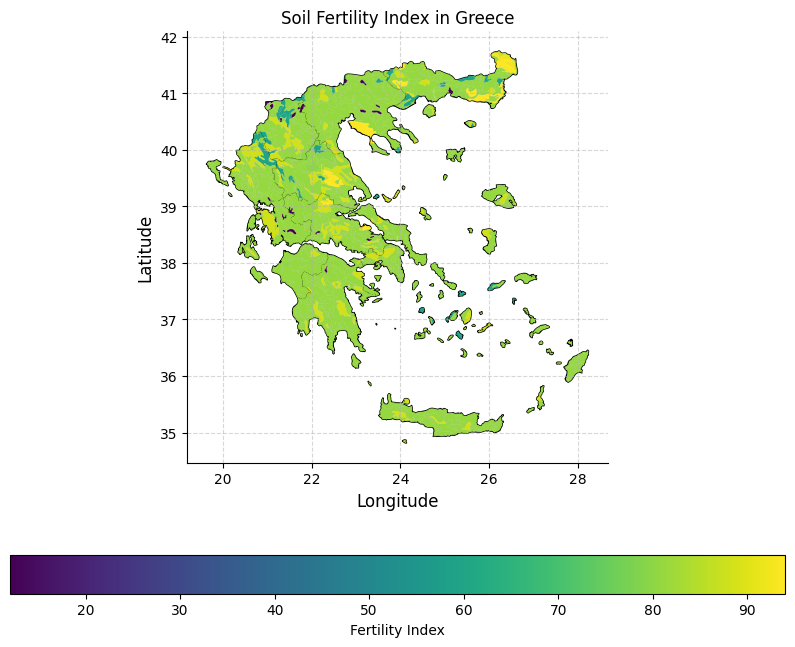

In [ ]:
# 5. Visualize soil properties on the Greece map

# Plot the Greece shapefile as the basemap
fig, ax = plt.subplots(figsize=(10, 8))
greece_shapefile.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the soil fertility index for Greece
soil_data.plot(column='fertility_index', legend=True, cmap='viridis',
                 ax=ax, legend_kwds={'label': "Fertility Index", 'orientation': "horizontal"})

ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Remove axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Soil Fertility Index in Greece')
plt.show()

# Water Distribution Data

Uses the **Global Water Watch**: https://api.globalwaterwatch.earth/docs

In [ ]:
# API endpoint and parameters
url = "https://api.globalwaterwatch.earth/reservoir/geometry/ts/surface_water_area"
params = {
    "agg_period": "monthly",
    "start": "2023-01-01T00:00:00",
    "stop": "2024-01-01T00:00:00"
}

# Extract coordinates and structure them in the required format
coordinates = []
for point in greece_shapefile.geometry:
  if isinstance(point, shapely.geometry.point.Point):
      coordinates.append([point.x, point.y])
  elif isinstance(point, shapely.geometry.polygon.Polygon):
      coordinates.append(list(point.exterior.coords))
  elif isinstance(point, shapely.geometry.multipolygon.MultiPolygon):
      for polygon in point.geoms:
          coordinates.append(list(polygon.exterior.coords))
  else:
      print(f"Unsupported geometry type: {type(point)}")

# Convert to the desired format
formatted_coordinates = []
for polygon in coordinates:
    formatted_polygon = []
    for coord in polygon:
        formatted_polygon.append([coord[0], coord[1]])  # Extract longitude and latitude
    formatted_coordinates.append(formatted_polygon)

batch_size = 1


# Create batches of coordinates
coordinate_batches = [
    formatted_coordinates[i: i + batch_size] for i in range(0, len(formatted_coordinates), batch_size)
]
len(coordinate_batches)
coordinate_batches
# Send requests in batches

batch_data = []
for batch in coordinate_batches:
    # Construct the request body for the current batch
    request_body = {
        "type": "Polygon",
        "coordinates": batch
    }

    # print(request_body)

    try:
        response = requests.post(url, params=params, json=request_body)
        response.raise_for_status()

        # Process the JSON response for the batch
        data = response.json()
        batch_data.append(data)
        # print(f"Batch data: {data}")

    except requests.exceptions.RequestException as e:
        print(f"Error making API request for batch: {e}")
    except ValueError as e:
        print(f"Error decoding JSON response for batch: {e}")

In [ ]:
print(batch_data[0])

{'agg_period': 'monthly', 'variable_name': 'surface_water_area', 'variable_unit': 'm2', 'data': [{'value': 320538846.9957212, 't': '2023-01-01T00:00:00'}, {'value': 311624944.3442426, 't': '2023-02-01T00:00:00'}, {'value': 321355914.86600155, 't': '2023-03-01T00:00:00'}, {'value': 318908373.80889684, 't': '2023-04-01T00:00:00'}, {'value': 308541790.2708135, 't': '2023-05-01T00:00:00'}, {'value': 313490070.2753444, 't': '2023-06-01T00:00:00'}, {'value': 323930964.8994235, 't': '2023-07-01T00:00:00'}, {'value': 316290129.10534155, 't': '2023-08-01T00:00:00'}, {'value': 321367061.98350865, 't': '2023-09-01T00:00:00'}, {'value': 317533874.908487, 't': '2023-10-01T00:00:00'}, {'value': 322676641.0847526, 't': '2023-11-01T00:00:00'}, {'value': 317102445.57500744, 't': '2023-12-01T00:00:00'}], 'source_data': None}


### Visualization

POLYGON ((20.739552404152754 40.30916637342859, 20.755042764005314 40.338624156710694, 20.765998169170107 40.354282135912186, 20.770442341269742 40.36255034719193, 20.77385298798947 40.374901031215806, 20.773336224127593 40.38533967149679, 20.76899540054647 40.41257312648086, 20.77064904663068 40.4219782382711, 20.779537394738867 40.429006252861946, 20.800311319557633 40.43277862189555, 20.809199666395656 40.43660268566783, 20.817364543726605 40.44683462173032, 20.82129194932535 40.4563947404951, 20.826666302808977 40.464818030735415, 20.839998820526908 40.47163930786918, 20.866767213898488 40.472052731523945, 20.88960819334717 40.46373279375276, 20.911932414731922 40.45954703396146, 20.93684045279726 40.47251779093454, 20.946452271995458 40.48290478334018, 20.949759563893885 40.48786571939999, 20.95265344200185 40.49365346301669, 20.951929971654803 40.50605579465207, 20.95792443881393 40.51494415129265, 20.968569781570658 40.52057687089844, 20.981488892937872 40.52326407574806, 20.988

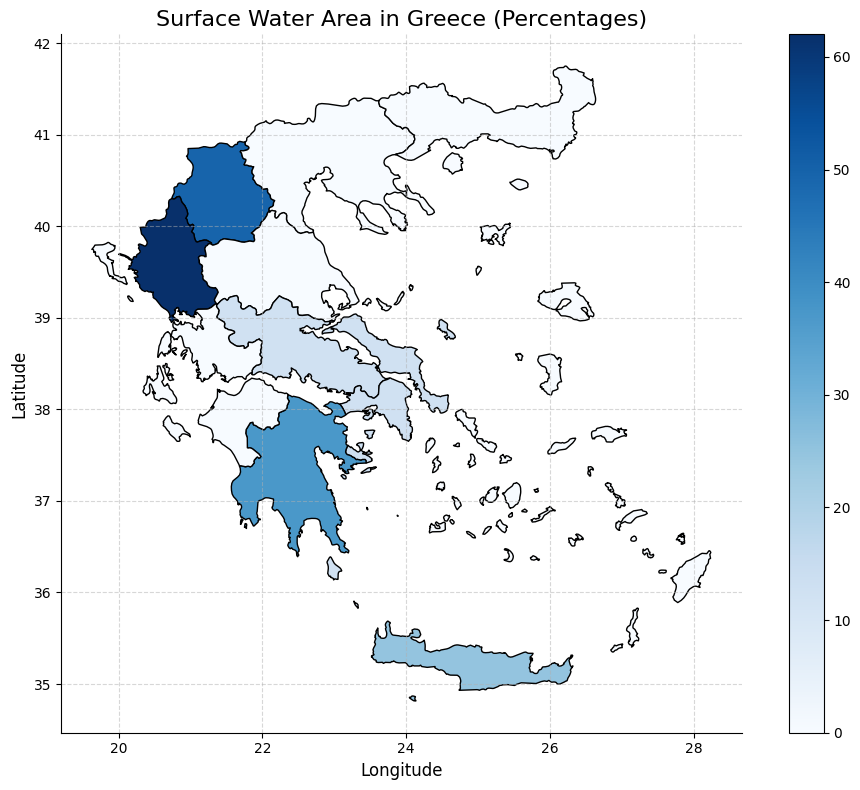

In [ ]:
# --- Visualization ---

# Create a new column to store water distribution percentage
greece_shapefile['water_distribution'] = None

# Assuming you have a list called 'batch_data' with the same length as 'coordinate_batches'
greece = greece_shapefile
print(greece.geometry[0])
# Create a new column in the GeoDataFrame to store the 'value'
greece['value'] = None

# Iterate over batches and corresponding data
for i, batch in enumerate(coordinate_batches):
    data_dict = batch_data[i]  # Get the corresponding dict for the batch

    # Extract the 'value' from the data_dict
    # (Adjust this based on the actual structure of your data_dict)
    if data_dict['data']:
      value = data_dict['data'][0]['value']  # Take the first value for simplicity
    else:
      value = 0

    # Create a Polygon from the coordinates in the batch
    # Flatten the list of coordinates before creating the Polygon
    flattened_batch = [coord for sublist in batch for coord in sublist]
    polygon = shapely.geometry.Polygon(flattened_batch)

    # Find the corresponding geometry in the shapefile that intersects the Polygon
    for j, shapefile_polygon in enumerate(greece.geometry):
        if shapefile_polygon.intersects(polygon):
            # Assign the 'value' to the corresponding row in the GeoDataFrame
            greece.loc[j, 'value'] = value
            greece_shapefile.loc[j, 'water_distribution'] = value
            break  # Move to the next batch once a match is found

# --- Calculate percentages ---

for i, val in enumerate(greece['value']):
  if val == None:
    greece.loc[i, 'value'] = 0

# Calculate the total value
total_value = sum(greece['value'])

# Calculate percentages for each value
greece['percentage'] = ((greece['value'] / total_value) * 100)
# greece['percentage'] = greece['percentage'].apply(lambda x: round(x, 1))

for i, val in enumerate(greece['percentage']):
  greece.loc[i, 'percentage'] = int(val)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))  # Adjust figure size as needed

# Plot the choropleth map with customized appearance
greece.plot(
    column='percentage',
    cmap='Blues',
    ax=ax,
    edgecolor='black',  # Add black borders to polygons
)

# Add title and labels
ax.set_title("Surface Water Area in Greece (Percentages)", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Remove axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a colorbar for better visualization
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=greece["percentage"].min(), vmax=greece["percentage"].max()))
sm._A = []  # This is necessary to prevent an error
cbar = fig.colorbar(sm, ax=ax)

plt.tight_layout()  # Adjust layout to prevent overlapping elements
# Show the plot
plt.show()

In [ ]:
# Verify that the sum of percentages adds up to 100
total_percentage = greece['percentage'].sum()
print(f"Total Percentage: {total_percentage}%")

if total_percentage == 100:
    print("The data adds up to 100%.")
else:
    print(f"The data does not add up to 100%. Total is {total_percentage}%. Please investigate.")


Total Percentage: 98%
The data does not add up to 100%. Total is 98%. Please investigate.


# Analysis

> Analysis and visualization of the above data acquired and mapped on the greece shapefile



## Regional Visualization




### 1.   **Solar Irradiance**





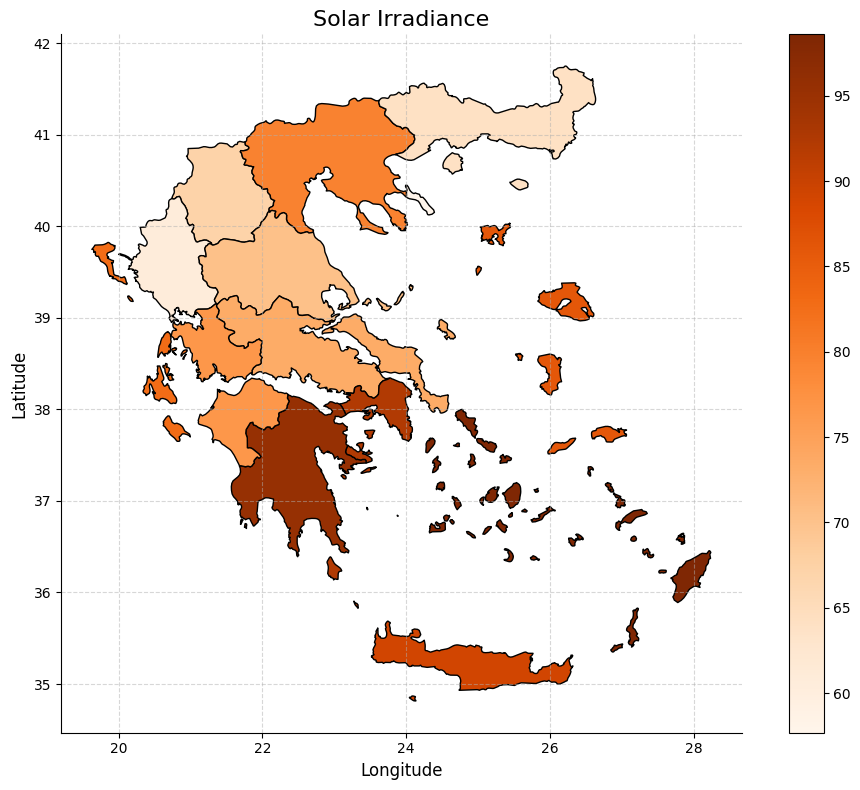

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))  # Adjust figure size as needed

# Plot the choropleth map with customized appearance
greece_shapefile.plot(
    column='AVG_GHI',
    cmap='Oranges',
    ax=ax,
    edgecolor='black',  # Add black borders to polygons
)

# Add title and labels
ax.set_title("Solar Irradiance", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Remove axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a colorbar for better visualization
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap="Oranges", norm=plt.Normalize(vmin=greece_shapefile["AVG_GHI"].min(), vmax=greece_shapefile["AVG_GHI"].max()))
sm._A = []  # This is necessary to prevent an error
cbar = fig.colorbar(sm, ax=ax)

plt.tight_layout()  # Adjust layout to prevent overlapping elements
# Show the plot
plt.show()

### 2.   **Power Line Distribution**


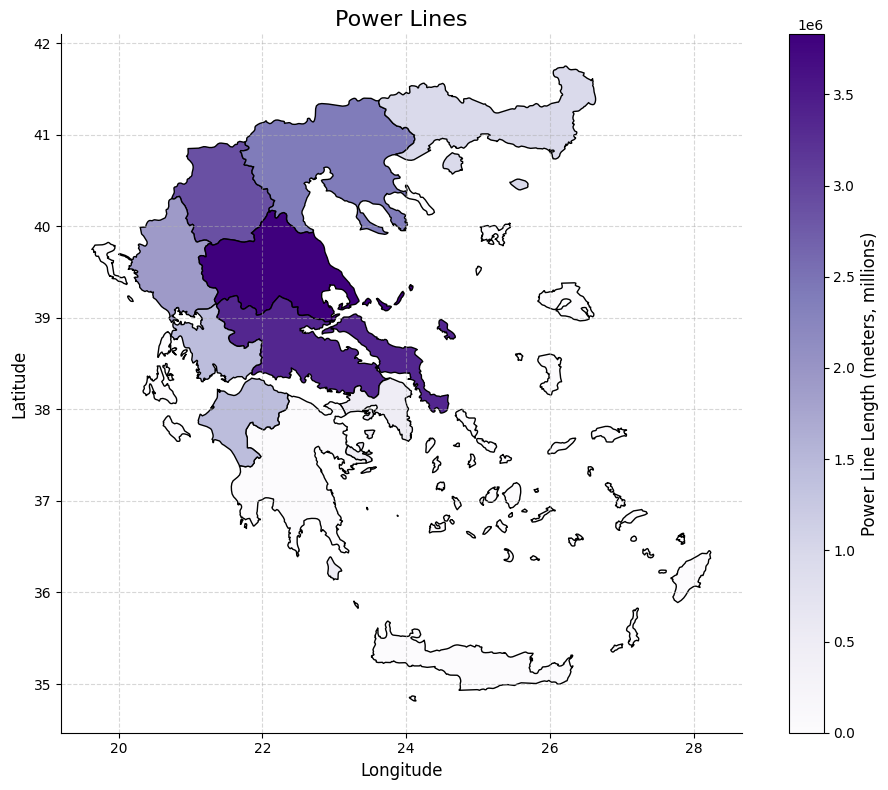

In [ ]:
# Add a new column to store power line information
greece_shapefile['power_lines'] = None  # More descriptive column name

# Reproject power lines to a projected CRS (e.g., UTM)
power_lines_gdf = power_grid_gdf.to_crs(epsg=32634)  # Example UTM zone for Greece

# Associate power line data with regions
for i, region in enumerate(greece_shapefile.geometry):
    # Find power lines that intersect the region
    intersecting_lines = power_lines_gdf[power_grid_gdf.intersects(region)]

    # Calculate total length of intersecting lines (in meters)
    total_length = intersecting_lines.geometry.length.sum()

    greece_shapefile.loc[i, 'power_lines'] = total_length

# Now the 'power_lines' column in the greece_shapefile contains
# the total length of power lines intersecting each region (in meters).

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))  # Adjust figure size as needed

# Plot the choropleth map with customized appearance
greece_shapefile.plot(
    column='power_lines',
    cmap='Purples',
    ax=ax,
    edgecolor='black',  # Add black borders to polygons
)

# Add title and labels
ax.set_title("Power Lines", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Remove axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a colorbar for better visualization
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap="Purples", norm=plt.Normalize(vmin=greece_shapefile["power_lines"].min(), vmax=greece_shapefile["power_lines"].max()))
sm._A = []  # This is necessary to prevent an error
cbar = fig.colorbar(sm, ax=ax)

# Add a label to the colorbar for units
cbar.set_label("Power Line Length (meters, millions)", fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlapping elements
# Show the plot
plt.show()


### 3.   **Agricultural Suitability**


In [ ]:
# Add a new column to store slope suitability
greece_shapefile['suitable_slope'] = None
greece_copy = greece_shapefile.copy()

# Open the slope raster within the loop
with rasterio.open('/content/drive/MyDrive/Greece_prj_content/EuroDEM/suitable_slope_greece.tif') as slope_raster:
  # Reproject the shapefile to the DEM's CRS if necessary
  if greece_copy.crs != src.crs:
      greece_copy = greece_copy.to_crs(slope_raster.crs)
      # Associate slope suitability with regions
  for i, region in enumerate(greece_copy.geometry):
    # Mask the slope raster to the region's geometry
    region_slope, _ = mask(slope_raster, [region], crop=True)
    # Calculate the percentage of suitable slope within the region
    suitable_pixels = np.count_nonzero(region_slope == 1)
    total_pixels = region_slope.size
    percentage_suitable = (suitable_pixels / total_pixels) * 100 if total_pixels > 0 else 0

    # Assign the percentage to the shapefile
    greece_shapefile.loc[i, 'suitable_slope'] = percentage_suitable

# Now the 'suitable_slope' column in greece_shapefile contains
# the percentage of suitable slope area for each region.

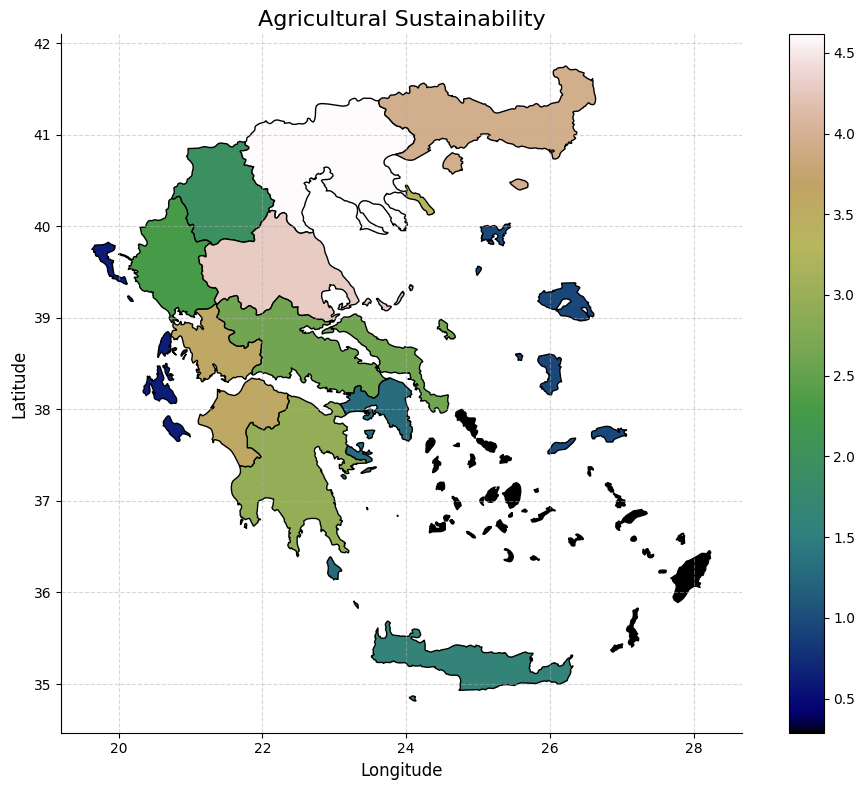

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))  # Adjust figure size as needed

# Plot the choropleth map with customized appearance
greece_shapefile.plot(
    column='suitable_slope',
    cmap='gist_earth',
    ax=ax,
    edgecolor='black',  # Add black borders to polygons
)

# Add title and labels
ax.set_title("Agricultural Sustainability", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Remove axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a colorbar for better visualization
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap="gist_earth", norm=plt.Normalize(vmin=greece_shapefile["suitable_slope"].min(), vmax=greece_shapefile["suitable_slope"].max()))
sm._A = []  # This is necessary to prevent an error
cbar = fig.colorbar(sm, ax=ax)

plt.tight_layout()  # Adjust layout to prevent overlapping elements
# Show the plot
plt.show()

### 4.   **Fertility Index**


In [ ]:
# Add new columns to greece_shapefile to store soil attributes
greece_shapefile['OC_TOP'] = None
greece_shapefile['CEC_TOP'] = None
greece_shapefile['AWC_TOP'] = None
greece_shapefile['fertility_index'] = None

# Associate soil data with regions in greece_shapefile
for i, region in enumerate(greece_shapefile.geometry):
    # Find soil data that intersects the region
    intersecting_soil = soil_data[soil_data.intersects(region)]

    if not intersecting_soil.empty:
        # Calculate average soil attributes for the region
        avg_oc_top = intersecting_soil['OC_TOP'].mean()
        avg_cec_top = intersecting_soil['CEC_TOP'].mean()
        avg_awc_top = intersecting_soil['AWC_TOP'].mean()
        avg_fertility_index = intersecting_soil['fertility_index'].mean()

        # Assign average values to the corresponding region in greece_shapefile
        greece_shapefile.loc[i, 'OC_TOP'] = avg_oc_top
        greece_shapefile.loc[i, 'CEC_TOP'] = avg_cec_top
        greece_shapefile.loc[i, 'AWC_TOP'] = avg_awc_top
        greece_shapefile.loc[i, 'fertility_index'] = avg_fertility_index

# Now the greece_shapefile contains soil data associated with each region.


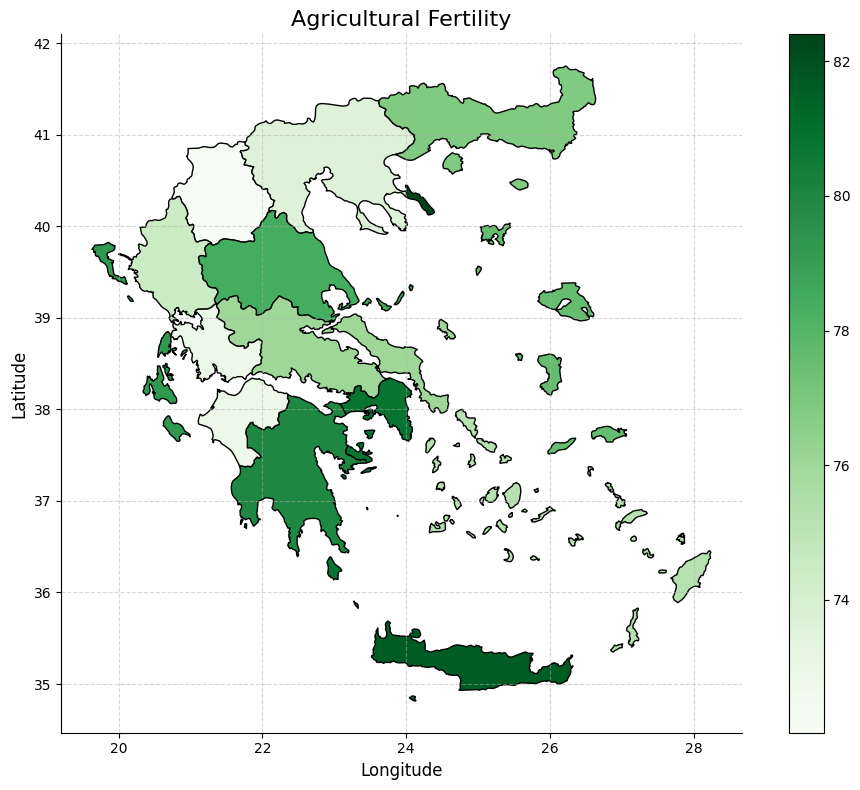

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))  # Adjust figure size as needed

# Plot the choropleth map with customized appearance
greece_shapefile.plot(
    column='fertility_index',
    cmap='Greens',
    ax=ax,
    edgecolor='black',  # Add black borders to polygons
)

# Add title and labels
ax.set_title("Agricultural Fertility", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Remove axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a colorbar for better visualization
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=greece_shapefile["fertility_index"].min(), vmax=greece_shapefile["fertility_index"].max()))
sm._A = []  # This is necessary to prevent an error
cbar = fig.colorbar(sm, ax=ax)

plt.tight_layout()  # Adjust layout to prevent overlapping elements
# Show the plot
plt.show()

### 5.   **Water Distribution**


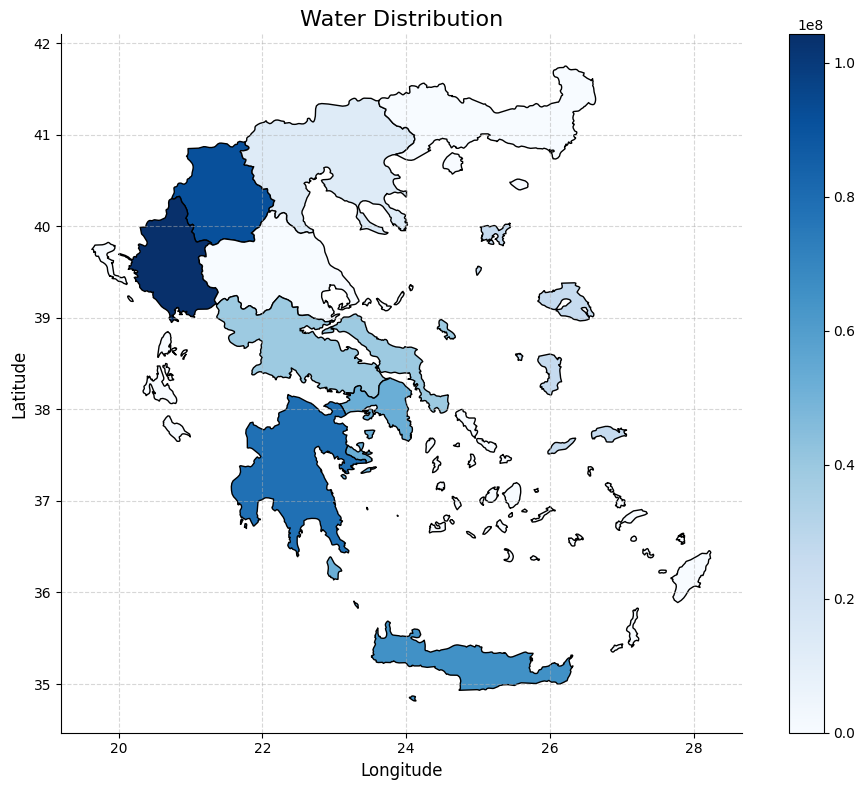

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))  # Adjust figure size as needed

# Plot the choropleth map with customized appearance
greece_shapefile.plot(
    column='water_distribution',
    cmap='Blues',
    ax=ax,
    edgecolor='black',  # Add black borders to polygons
)

# Add title and labels
ax.set_title("Water Distribution", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Remove axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a colorbar for better visualization
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=greece_shapefile["water_distribution"].min(), vmax=greece_shapefile["water_distribution"].max()))
sm._A = []  # This is necessary to prevent an error
cbar = fig.colorbar(sm, ax=ax)

plt.tight_layout()  # Adjust layout to prevent overlapping elements
# Show the plot
plt.show()

In [ ]:
# Fill missing data only in rows 4 and 9 for specific columns
greece_shapefile.loc[4, 'water_distribution'] = 0.1
greece_shapefile.loc[9, 'water_distribution'] = 0.1

# Fill for other columns if needed
greece_shapefile.loc[4, 'suitability_score'] = 0.1
greece_shapefile.loc[9, 'suitability_score'] = 0.1

# Verify the changes
print(greece_shapefile.loc[[4, 9], :])



     id           name                  source  \
4  GR69     Ayion Oros  https://simplemaps.com   
9   GRG  Dytiki Ellada  https://simplemaps.com   

                                            geometry     region_name  \
4  POLYGON ((24.00167 40.31977, 24.00487 40.32922...     Mount Athos   
9  MULTIPOLYGON (((21.06031 39.03905, 21.05869 39...  Western Greece   

     AVG_GHI     MAX_GHI water_distribution value percentage     power_lines  \
4  57.676042  280.141667                0.1     0          0             0.0   
9  81.651042  377.029762                0.1     0          0  1000638.801924   

  suitable_slope    OC_TOP    CEC_TOP     AWC_TOP fertility_index  \
4       1.383083       2.0       20.0       190.0            82.4   
9         2.0267  1.967213  19.098361  171.311475       74.655738   

   suitability_score  
4                0.1  
9                0.1  




## Calculating the **Suitability Score** for agrivoltaic projects in each Region









In [ ]:
# Select the columns to normalize
columns_to_normalize = [
    'AVG_GHI',
    'power_lines',
    'suitable_slope',
    'fertility_index',
    'water_distribution',
]

# Normalize the selected columns using Min-Max scaling
for col in columns_to_normalize:
    min_val = greece_shapefile[col].min()
    max_val = greece_shapefile[col].max()
    greece_shapefile[col] = (greece_shapefile[col] - min_val) / (max_val - min_val)


In [ ]:
# Assign weights to factors
weights = {
    'AVG_GHI': 4,
    'power_lines': 1,
    'suitable_slope': 2,
    'fertility_index': 3,
    'water_distribution': 2
}

In [ ]:
# Create a new column to store suitability score
greece_shapefile['suitability_score'] = None

# Calculate weighted score for each region
greece_shapefile['suitability_score'] = (
    greece_shapefile['AVG_GHI'] * weights['AVG_GHI'] +
    greece_shapefile['suitable_slope'] * weights['suitable_slope'] +
    greece_shapefile['fertility_index'] * weights['fertility_index'] +
    greece_shapefile['water_distribution'] * weights['water_distribution'] +
    greece_shapefile['power_lines'] * weights['power_lines']
)

# Scale the scores proportionally to a 0–100 range
scale_factor = 100 / greece_shapefile['suitability_score'].max()

greece_shapefile['suitability_score_normalized'] = greece_shapefile['suitability_score'] * scale_factor

# Optional: Convert scores to integers for simplicity
greece_shapefile['suitability_score_normalized'] = greece_shapefile['suitability_score_normalized'].astype('int')


In [ ]:
print(greece_shapefile[['suitability_score', 'suitability_score_normalized']])

   suitability_score  suitability_score_normalized
0            3.71064                            54
1           5.788242                            84
2           5.760518                            84
3           5.454543                            79
4           3.506184                            51
5           6.836371                           100
6           5.920676                            86
7           6.136526                            89
8           6.619711                            96
9           4.168478                            60
10          6.086337                            89
11          6.072689                            88
12          5.277385                            77
13          5.078673                            74


In [ ]:
# Create a new column to store suitability class
greece_shapefile['suitability_class'] = None

# Classify regions based on suitability score
greece_shapefile['suitability_class'] = pd.cut(
    greece_shapefile['suitability_score_normalized'],
    bins = [0, 0.33, 0.67, 1],
    labels=['Low', 'Moderate', 'High'],
)

In [ ]:
# Define a dictionary mapping the current region index to the new name
region_names = {
    0: "Western Macedonia",
    1: "Epirus",
    2: "Central Macedonia",
    3: "Eastern Macedonia and Thrace",
    4: "Mount Athos",
    5: "Thessaly",
    6: "Central Greece",  # Assuming missing region name
    7: "Attica",
    8: "Peloponnese",
    9: "Western Greece",
    10: "Crete",
    11: "South Aegean",
    12: "North Aegean",
    13: "Ionian Islands",
}

# Rename the regions based on the dictionary
greece_shapefile['name'] = greece_shapefile.index.map(region_names)

# Verify the updated names
print(greece_shapefile[['name']])


                            name
0              Western Macedonia
1                         Epirus
2              Central Macedonia
3   Eastern Macedonia and Thrace
4                    Mount Athos
5                       Thessaly
6                 Central Greece
7                         Attica
8                    Peloponnese
9                 Western Greece
10                         Crete
11                  South Aegean
12                  North Aegean
13                Ionian Islands


In [ ]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))  # Adjust figure size as needed

# Plot the choropleth map with customized appearance
greece_shapefile.plot(
    column='suitability_score_normalized',  # Use normalized suitability score
    cmap='plasma',  # Use the 'plasma' colormap
    ax=ax,
    edgecolor='black',  # Add black borders to polygons
)

# Add region names and suitability scores as labels
for idx, row in greece_shapefile.iterrows():
    if row.geometry.is_empty or row.geometry is None:
        continue  # Skip empty or invalid geometries
    # Get the centroid of the geometry
    centroid = row.geometry.centroid
    # Create a label combining the region name and suitability score
    label = f"{row['name']}\n{row['suitability_score_normalized']}"
    # Add the label to the plot
    ax.text(
        centroid.x, centroid.y,
        label,
        fontsize=8, color='black',  # All labels are black
        ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.7)  # Optional background
    )

# Add title and labels
ax.set_title("Suitability Score for Optimal Agrivoltaics locations for Agricultural Cultivation in Greece", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Remove axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a colorbar for better visualization
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(
    cmap="plasma",  # Match the colormap used in the plot
    norm=plt.Normalize(
        vmin=greece_shapefile["suitability_score_normalized"].min(),
        vmax=greece_shapefile["suitability_score_normalized"].max()
    )
)
sm._A = []  # Prevent an error
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Suitability Score (1–100)", fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()  # Prevent overlapping elements
plt.show()

